In [29]:
from __future__ import division

from pylab import *
import scipy
import time
import utils
import hrr_utils

#import imnet_utils as imut
import sklearn
from sklearn.decomposition import PCA, FastICA, TruncatedSVD, NMF
from scipy import stats

%matplotlib inline


plt.rcParams.update({'font.size': 11})
plt.rcParams.update({'text.usetex': True})
plt.rcParams.update({'axes.titlesize': 'xx-large'})
plt.rcParams.update({'axes.labelsize': 'xx-large'})
plt.rcParams.update({'xtick.labelsize': 'x-large', 'ytick.labelsize': 'x-large'})
plt.rcParams.update({'legend.fontsize': 'x-large'})
plt.rcParams.update({'font.family': 'serif'})
plt.rcParams.update({'font.family': 'serif', 'font.serif':['Computer Modern']})

In [31]:
import colormaps

In [157]:
def ngram_encode(ngram_str, letter_vecs, alph):
    vec = np.zeros(letter_vecs.shape[1])
    
    full_str = '#' + ngram_str + '.'
    
    
    for il, l in enumerate(full_str[:-2]):
        trivec = letter_vecs[alph.find(full_str[il]), :]
        for c3 in range(1, 3):
            trivec = trivec * np.roll(letter_vecs[alph.find(full_str[il+c3]), :], c3)
            
        vec += trivec
    return vec

def ngram_encode_cl(ngram_str, letter_vecs, alph):
    vec = ngram_encode(ngram_str, letter_vecs, alph)
    
    return 2* (vec + 0.1*(np.random.rand(letter_vecs.shape[1])-0.5) > 0) - 1

def bind(past, present):
    return np.multiply(past, present)

def reg_bind(past, present):
    pred = np.multiply(tv, present)
    return ((N-sim(pred, past))/float(N)) * np.multiply(past, present)

def bind_diff(past2, present1, present2):
    return np.multiply(present1, past2-present2)

def reg_bind_diff(past2, present1, present2):
    pred = np.multiply(tv, present1) + present2
    return ((N-sim(pred, past2))/float(N)) * np.multiply(past2-present2, present1)

def closed_bind(past, present):
    return np.dot(np.linalg.pinv(present), past)

def sim(x, y):
    if len(x.shape) == 1 or len(y.shape)==1:
        return np.dot(x, y)
    return np.sum(np.multiply(x, y), axis=1)

def state_setup(state_length, letter_vecs, N, D, n_steps):
    states = []
    coef_hists = []
    
    for i in range(state_length):
        states.append(np.random.randn(N))
    
    for i in range(1, state_length-1):
        states[i] = np.dot(letter_vecs.T, np.dot(states[i], letter_vecs.T))

    for i in range(1, state_length-1):
        states[i] = states[i]/norm(states[i])

    states[0] = letter_vecs[alph.find('#'), :]
    states[state_length-1] = letter_vecs[alph.find('.'), :]
    
    for i in range(1, state_length-1):
        coef_hists.append(np.zeros((n_steps, D)))
    
    return states, coef_hists

# EXPLAIN AWAY, PAST PRESENT TENSE DIFFERENCE
def explain_away_iterate(bound_vec, states, coef_hists, state_length, letter_vecs, N, D, n_steps):
    th_vec = bound_vec.copy()
    
    for i in range(n_steps):
        for j in range(1, state_length-1):
            coef_hists[j-1][i, :] = np.dot(letter_vecs, states[j]) / N
            ## Need to make sure that the largest absolute value is always positive,
            ## because the unbinding inference can flip 2 and be the same

            #mxidx = np.argmax(np.abs(coef_hists[j-1][i,:]))
            #states[j] *= np.sign(coef_hists[j-1][i, mxidx])
            
            if j == 1:
                ljd = (np.roll(th_vec * states[0] * np.roll(states[j+1], 2), -1) +
                  th_vec * np.roll(states[j+1], 1) * np.roll(states[j+2], 2)) / 2
            elif 1 < j < state_length-2:
                ljd = (np.roll(th_vec * states[j-2] * np.roll(states[j-1], 1), -2) +
                    np.roll(th_vec * states[j-1] * np.roll(states[j+1], 2), -1) +
                      th_vec * np.roll(states[j+1], 1) * np.roll(states[j+2], 2)) / 3
            else:
                ljd = (np.roll(th_vec * states[j-1] * np.roll(states[j+1], 2), -1) +
                   np.roll(th_vec * states[j-2] * np.roll(states[j-1], 1), -2)) / 2

            states[j] = np.dot(letter_vecs.T, np.dot(ljd, letter_vecs.T))/N + states[j]
            #states[j] = states[j]/norm(states[j])
            
        bv = states[0] * np.roll(states[1],1) * np.roll(states[2],2) 
              
        for j in range(1, state_length-2):
            bv += states[j] * np.roll(states[j+1],1) * np.roll(states[j+2],2) 
         
        #bv = 2*(bv > 0) - 1
        
        th_vec = bound_vec - bv

    return states, coef_hists


In [278]:
alph = 'abcdefghijklmnopqrstuvwxyz#.'

N = 10000
D = len(alph)

letter_vecs = 2 * (np.random.randn(D, N) < 0) - 1
letter_vecs1 = 2 * (np.random.randn(D, N) < 0) - 1

word_key = 2 * (np.random.randn(N) < 0) - 1

present_strs = ['run', 'walk', 'watch', 'catch', 'sit', 'jump', 'lump', 'bump', 'think', 'fade', 'shade', 'trade']
past_strs = ['ran', 'walked', 'watched', 'caught', 'sat', 'jumped', 'lumped', 'bumped', 'thought', 'faded', 'shaded', 'traded']
#present_strs = ['run', 'walk']
#past_strs = ['ran', 'walked']

ngram_strs = present_strs + past_strs
bound_vec = np.zeros(N)
reg_bound_vec = np.zeros(N)


for i in range(len(past_strs)):
    past = ngram_encode_cl(past_strs[i], letter_vecs, alph)
    pres = ngram_encode_cl(present_strs[i], letter_vecs, alph)
    past1 = ngram_encode_cl(past_strs[i], letter_vecs1, alph)
    pres1 = ngram_encode_cl(present_strs[i], letter_vecs1, alph)
    
    bound_diff = pres * (past1 - pres1)
    pred = reg_bound_vec*pres + pres1

    bound_vec += bound_diff
    reg_bound_vec += ((N-sim(pred, past1))/float(N)) * bound_diff

In [159]:
# predict a word in bound_vec
# regularized bind
seen = 'seen-'
word = 'catch'
word_length = 6
word_vec = ngram_encode_cl(word, letter_vecs, alph)
word_vec1 = ngram_encode_cl(word, letter_vecs1, alph)

pred_vec = word_vec * bound_vec + word_vec1

In [273]:
# predict a word in bound_vec
# regularized bind
seen = 'seen-'
word = 'watch'
word_length = 7
word_vec = ngram_encode_cl(word, letter_vecs, alph)
word_vec1 = ngram_encode_cl(word, letter_vecs1, alph)

pred_vec = word_vec * bound_vec + word_vec1

In [279]:
# predict a word in bound_vec
# regularized bind
seen = 'seen-'
word = 'fade'
word_length = 5
word_vec = ngram_encode_cl(word, letter_vecs, alph)
word_vec1 = ngram_encode_cl(word, letter_vecs1, alph)

pred_vec = word_vec * bound_vec + word_vec1

In [235]:
# predict a word in bound_vec
# regularized bind
seen = 'seen-'
word = 'think'
word_length = 7
word_vec = ngram_encode_cl(word, letter_vecs, alph)
word_vec1 = ngram_encode_cl(word, letter_vecs1, alph)

pred_vec = word_vec * bound_vec + word_vec1

In [182]:
# predict a word in bound_vec
# regularized bind
seen = 'seen-reg-'
word = 'catch'
word_length = 6
word_vec = ngram_encode_cl(word, letter_vecs, alph)
word_vec1 = ngram_encode_cl(word, letter_vecs1, alph)

pred_vec = word_vec * reg_bound_vec + word_vec1

In [225]:
# predict a word not bound_vec
# regularized bind
seen = 'unseen-'
word = 'pump'
word_length = 6
word_vec = ngram_encode_cl(word, letter_vecs, alph)
word_vec1 = ngram_encode_cl(word, letter_vecs1, alph)

pred_vec = word_vec * bound_vec + word_vec1

In [187]:
# predict a word not bound_vec
# regularized bind
seen = 'unseen-reg-'
word = 'pump'
word_length = 6
word_vec = ngram_encode_cl(word, letter_vecs, alph)
word_vec1 = ngram_encode_cl(word, letter_vecs1, alph)

pred_vec = word_vec * reg_bound_vec + word_vec1

In [210]:
# predict a word not bound_vec
# regularized bind
seen = 'unseen-'
word = 'evade'
word_length = 6
word_vec = ngram_encode_cl(word, letter_vecs, alph)
word_vec1 = ngram_encode_cl(word, letter_vecs1, alph)

pred_vec = word_vec * bound_vec + word_vec1

In [196]:
# predict a word not bound_vec
# regularized bind
seen = 'unseen-reg-'
word = 'evade'
word_length = 6
word_vec = ngram_encode_cl(word, letter_vecs, alph)
word_vec1 = ngram_encode_cl(word, letter_vecs1, alph)

pred_vec = word_vec * reg_bound_vec + word_vec1

In [83]:
# predict a word not bound_vec
# regularized bind
seen = 'seen-'
word = 'trade'
word_length = 6
word_vec = ngram_encode_cl(word, letter_vecs, alph)
word_vec1 = ngram_encode_cl(word, letter_vecs1, alph)

pred_vec = word_vec * bound_vec + word_vec1

In [205]:
# predict a word not bound_vec
# regularized bind
seen = 'seen-reg-'
word = 'trade'
word_length = 6
word_vec = ngram_encode_cl(word, letter_vecs, alph)
word_vec1 = ngram_encode_cl(word, letter_vecs1, alph)

pred_vec = word_vec * reg_bound_vec + word_vec1

In [284]:
n_steps = 101

In [285]:
states, coef_hists = state_setup(word_length+2, letter_vecs1, N, D, n_steps)
states, coef_hists = explain_away_iterate(pred_vec, states, coef_hists, word_length+2, letter_vecs1, N, D, n_steps)
#states, coef_hists = iterate(pred_vec, states, coef_hists, word_length+2, letter_vecs1, N, D, n_steps)

faded
figures/res_plot-seen-faded-N=10000-steps=101-reg=false-n171115


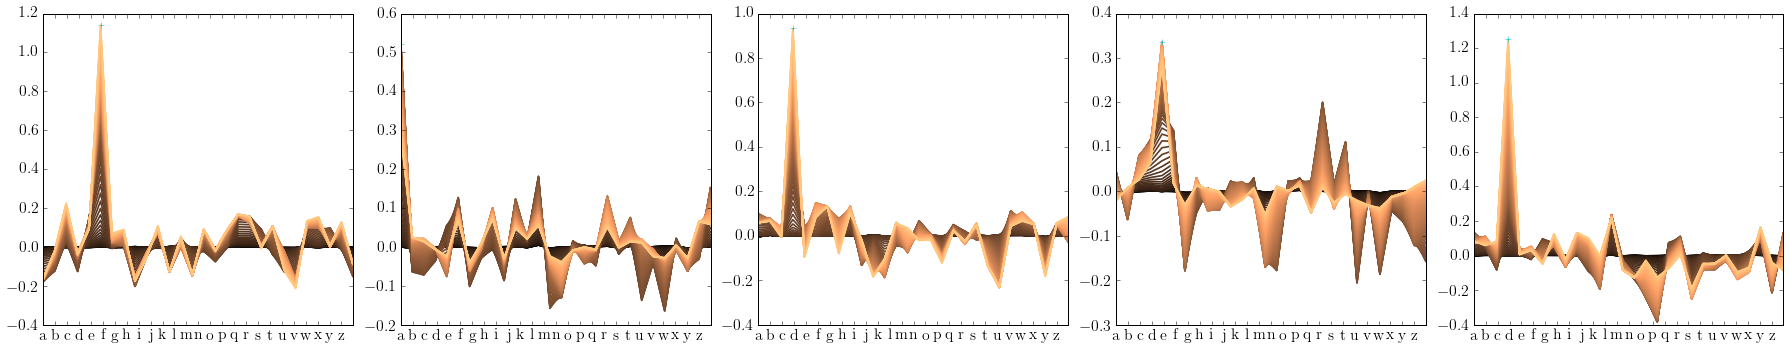

In [286]:
def resplot(word_length, states, coef_hists, title, N, nsteps, reg):
    pred = ''
    alphis = []
    for i in range(len(coef_hists)):
        alphis.append(np.argmax(np.abs(coef_hists[i][-1,:])))
        pred += alph[alphis[i]]

    print pred
    
    rows = 1
    columns = word_length

    fig, axes = plt.subplots(rows, columns, sharex='all', squeeze=True, figsize=(25,5))
    cols = get_cmap('copper', min(500,n_steps))
    x = np.linspace(0,len(alph)-2,len(alph)-2)
    labels = list(alph)
    plt.xticks(x, labels)
    
    for j in range(word_length):
        for i in range(min(500,n_steps)):
            # graphing the max positive at every iteration is not intuitive, since we should
            # be focusing on how our predicted letter's probability increases over time
            coef_hists[j][i,alphis[j]] = np.abs(coef_hists[j][i,alphis[j]])
            axes[j].plot(coef_hists[j][i,:], lw=1.7, c=cols(i))
            
        step, alphi = np.unravel_index(coef_hists[j].argmax(), coef_hists[j].shape)
        axes[j].plot(alphi, coef_hists[j][step, alphi], '+')
    
    plt.tight_layout()
    fname = 'figures/res_plot-'+title+pred+'-N='+str(N)+'-steps='+str(nsteps)+'-reg='+reg +'-n' + time.strftime('%y%m%d')
    print fname
    savefig(fname + '.png', format='png', transparent=True)
    savefig(fname + '.eps', format='eps', transparent=True)
    
resplot(word_length, states, list(coef_hists), seen, N, n_steps, 'false')

faded
figures/res_im-seen-faded-N=10000-steps=101-reg=false-n171115


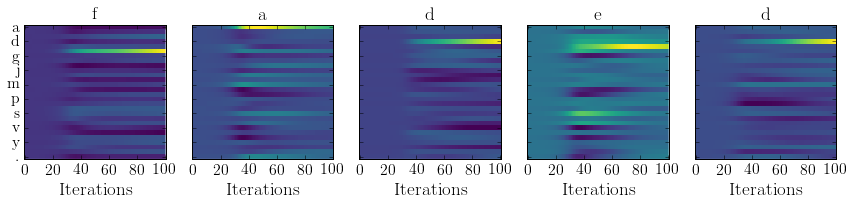

In [287]:
def resplot_im(word_length, states, coef_hists, title, N, nsteps, reg):
    pred = ''
    alphis = []
    for i in range(len(coef_hists)):
        alphis.append(np.argmax(np.abs(coef_hists[i][-1,:])))
        pred += alph[alphis[i]]

    print pred
    
    rows = 1
    columns = word_length

    fig, axes = plt.subplots(rows, columns, sharey='all', squeeze=True, figsize=(12,3))
    cols = get_cmap('copper', min(500,n_steps))
    x = np.linspace(0,len(alph)-2,len(alph)-2)
    
    y_idxs = np.arange(0, len(alph), 3)
    y_labels = np.array(list(alph))[y_idxs]
    
    for j in range(word_length):
        x_h = coef_hists[j][:n_steps, :]    
        axes[j].imshow(x_h.T, interpolation='none', aspect='auto', cmap=colormaps.viridis)

        axes[j].set_yticks(y_idxs)
        axes[j].set_yticklabels(y_labels)
        axes[j].set_xlabel('Iterations')
        axes[j].set_title(pred[j])
        #step, alphi = np.unravel_index(coef_hists[j].argmax(), coef_hists[j].shape)
        #axes[j].plot(alphi, coef_hists[j][step, alphi], '+')
    
    plt.tight_layout()
    fname = 'figures/res_im-'+title+pred+'-N='+str(N)+'-steps='+str(nsteps)+'-reg='+reg +'-n' + time.strftime('%y%m%d')
    print fname
    savefig(fname + '.png', format='png', transparent=True)
    savefig(fname + '.eps', format='eps', transparent=True)
    
    
resplot_im(word_length, states, list(coef_hists), seen, N, n_steps, 'false')

In [156]:
print coef_hists[0].shape

(70, 28)
